In [ ]:
from IPython.display import *

# Setup Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import *

# Setup numpy, pandas
import pandas as pd
import numpy as np

# Setup matplotlib
import matplotlib
import matplotlib.pyplot as plt
DEFAULT_W, DEFAULT_H = (16, 9)
matplotlib.rcParams["figure.figsize"] = [DEFAULT_W, DEFAULT_H]
matplotlib.rcParams["font.size"] = 15
matplotlib.rcParams['figure.dpi'] = 100

# Load data
FILE_NAME = "winequality_white.csv"
Y_COL_NAME = "quality"
data = pd.read_csv(FILE_NAME, sep=";")
data.head()

# I. Stats

### A. Distribution et informations statistiques de base

Mean values for each variable
fixed acidity             6.854788
volatile acidity          0.278241
citric acid               0.334192
residual sugar            6.391415
chlorides                 0.045772
free sulfur dioxide      35.308085
total sulfur dioxide    138.360657
density                   0.994027
pH                        3.188267
sulphates                 0.489847
alcohol                  10.514267
quality                   5.877909
dtype: float64

Median values for each variable
fixed acidity             6.80000
volatile acidity          0.26000
citric acid               0.32000
residual sugar            5.20000
chlorides                 0.04300
free sulfur dioxide      34.00000
total sulfur dioxide    134.00000
density                   0.99374
pH                        3.18000
sulphates                 0.47000
alcohol                  10.40000
quality                   6.00000
dtype: float64

Modes for each variable
   fixed acidity  volatile acidity  citric acid  resid

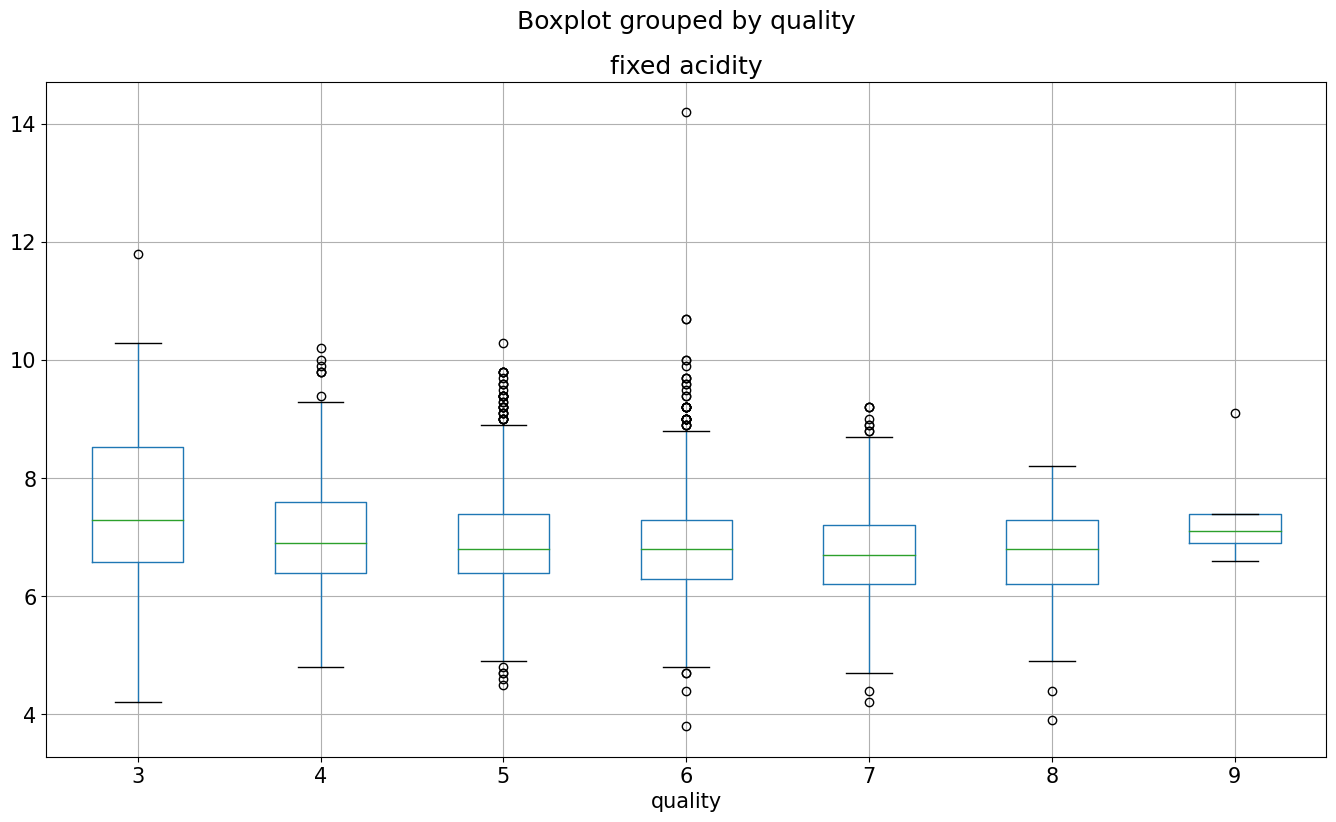

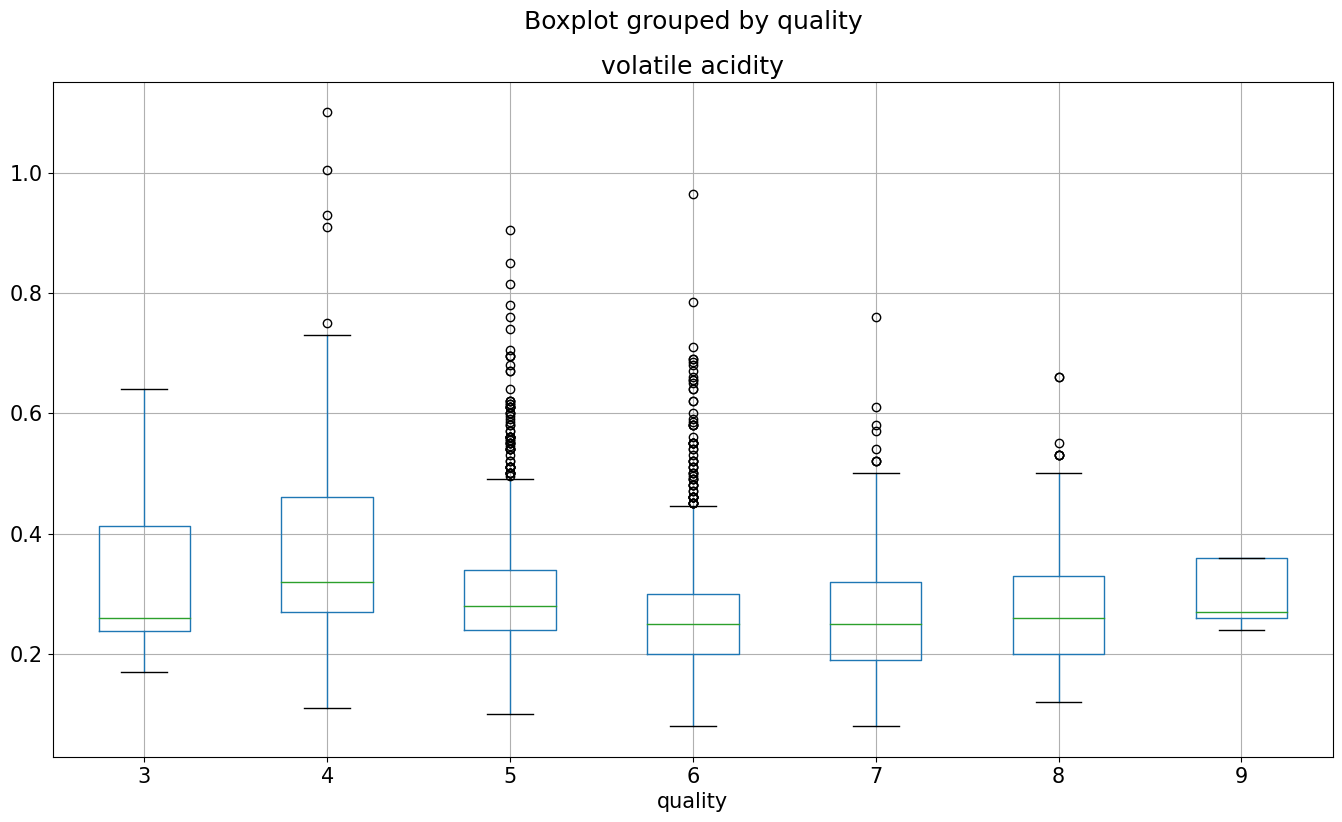

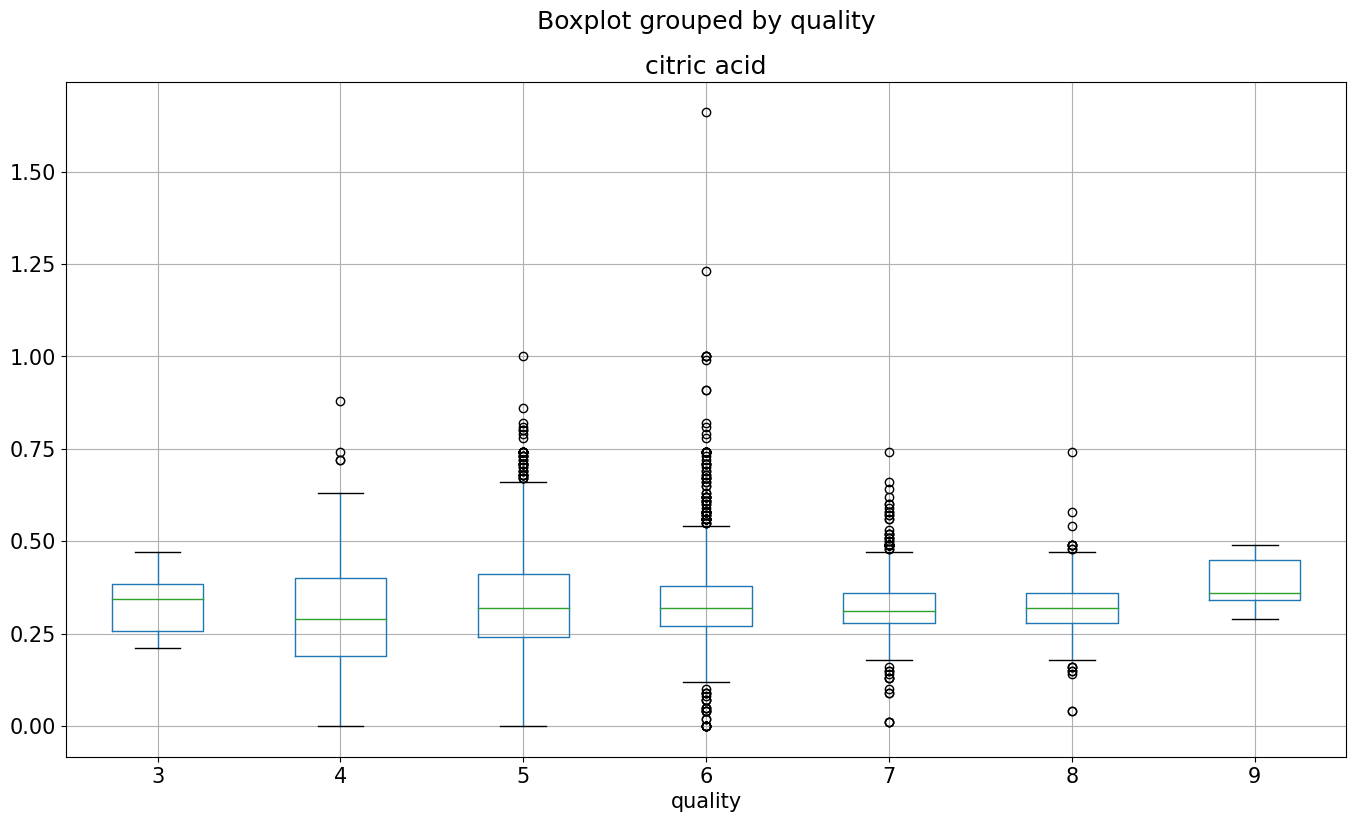

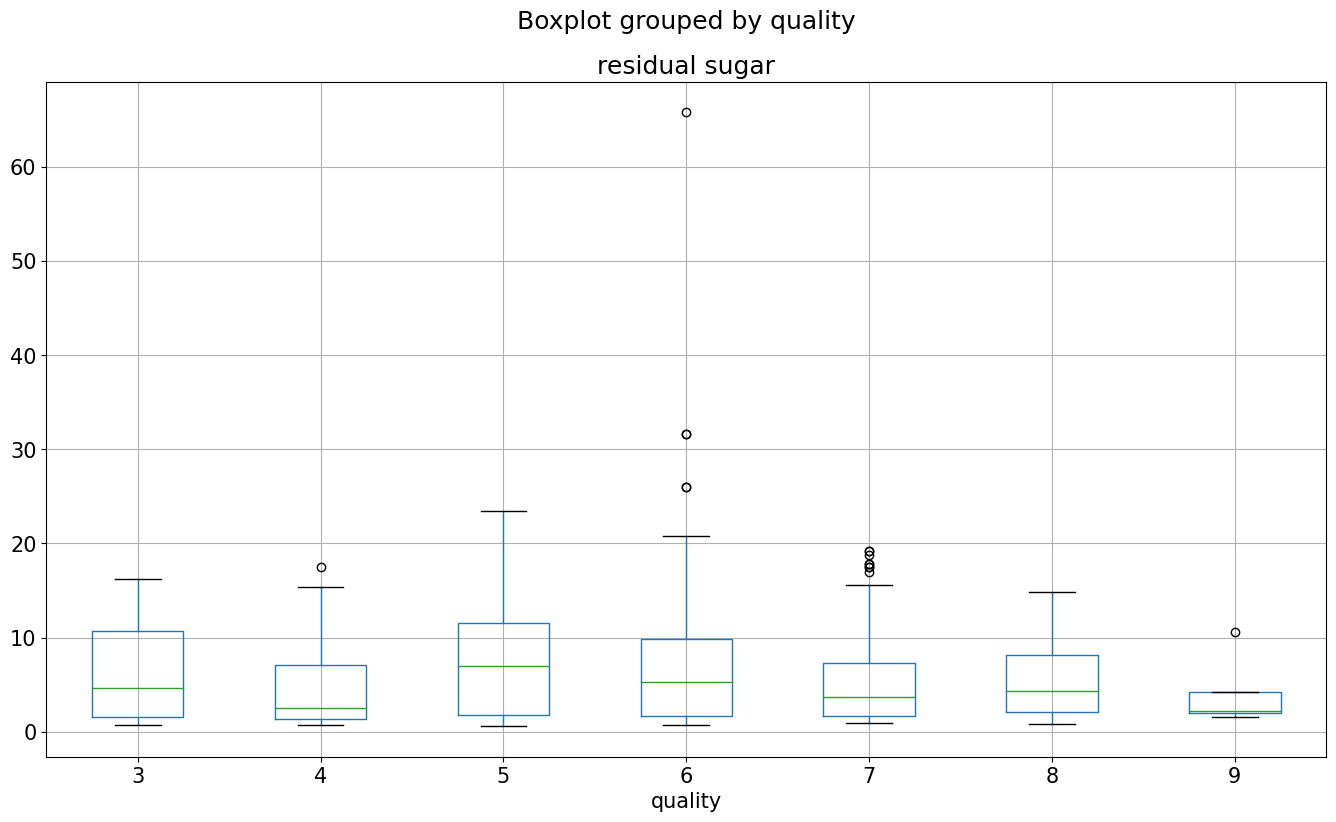

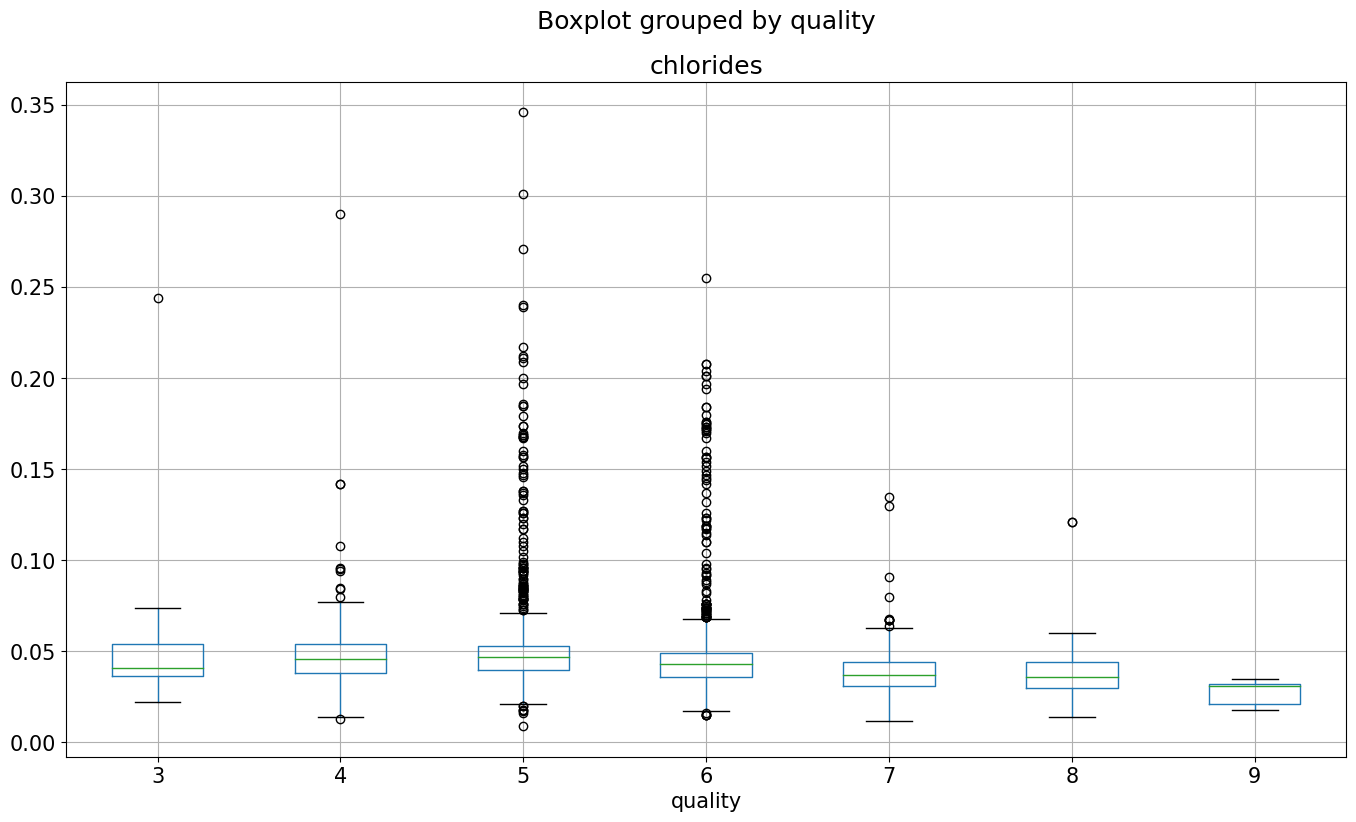

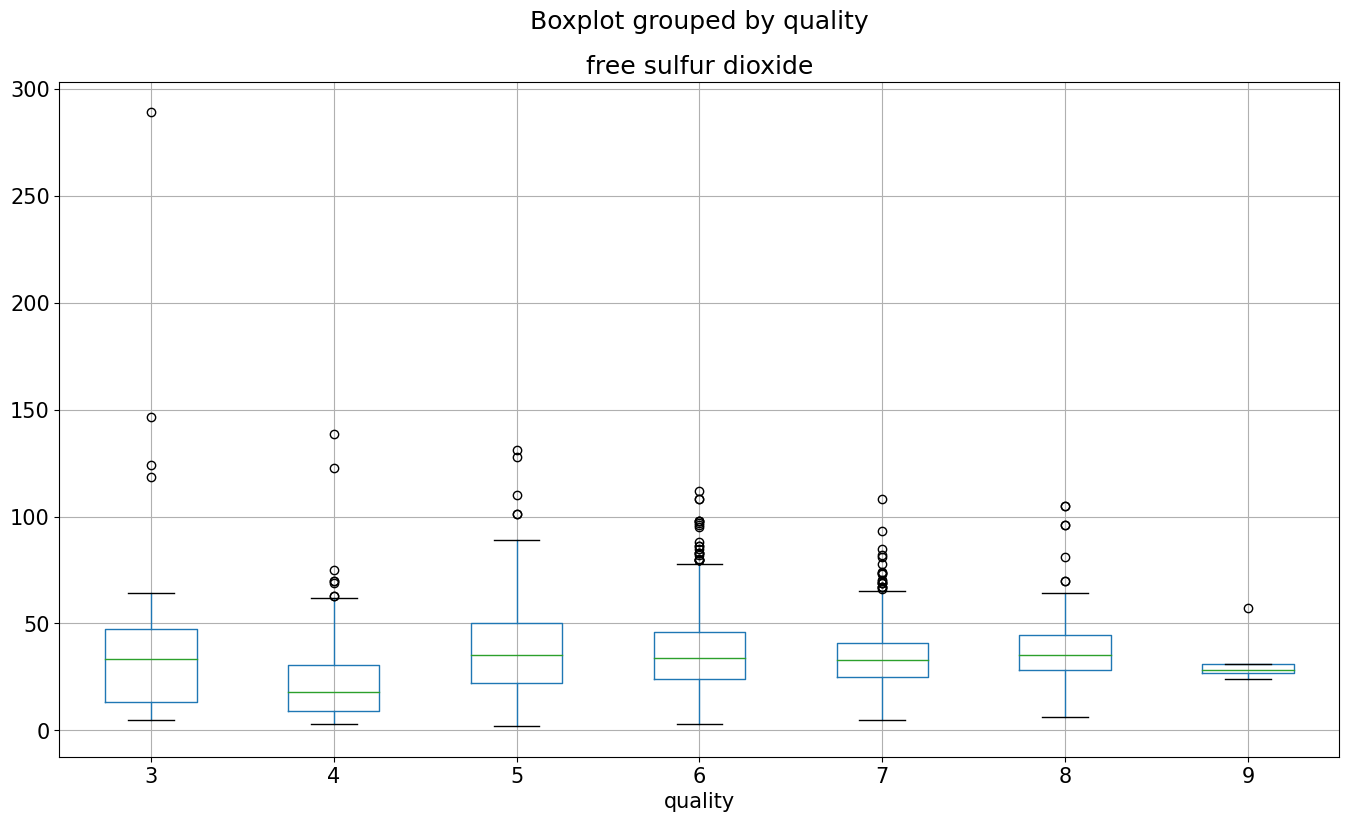

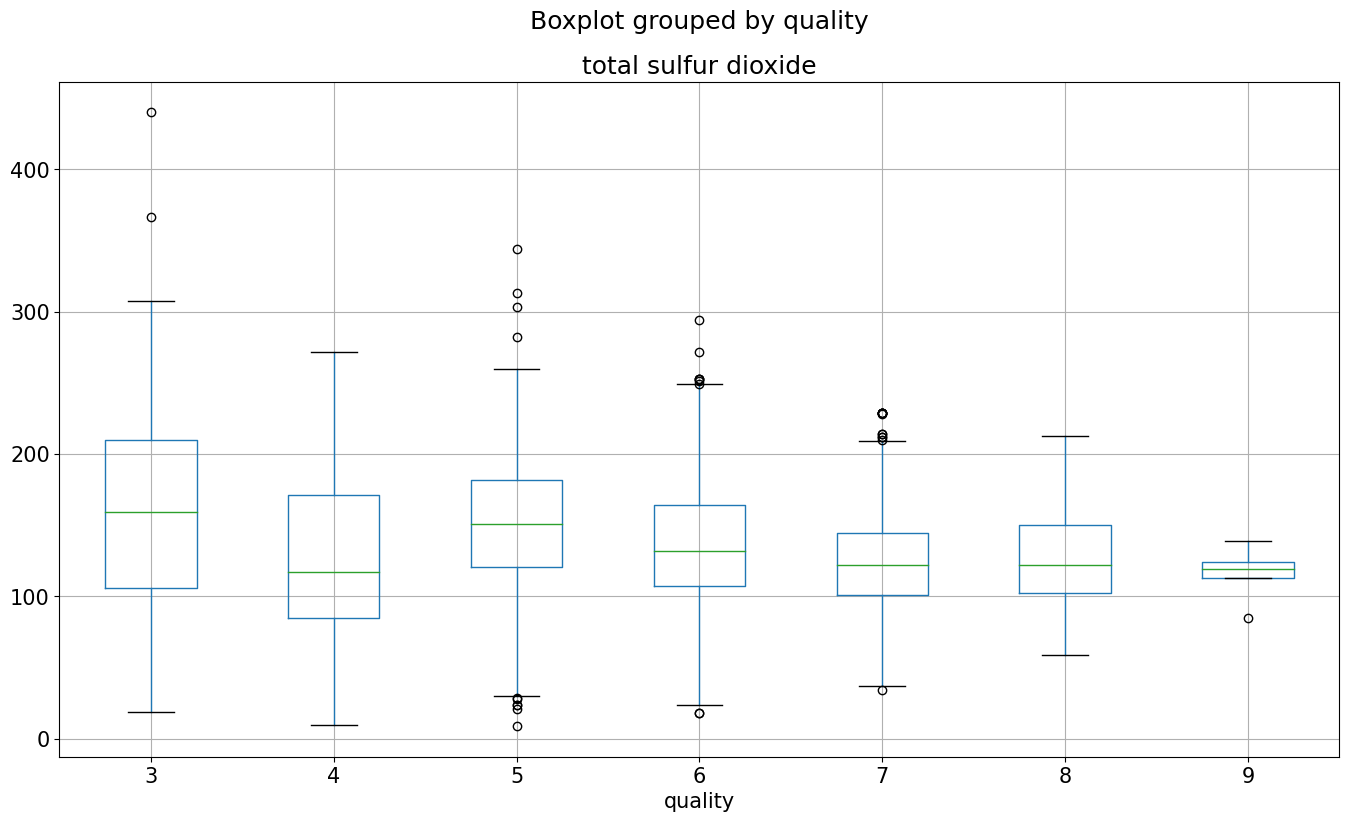

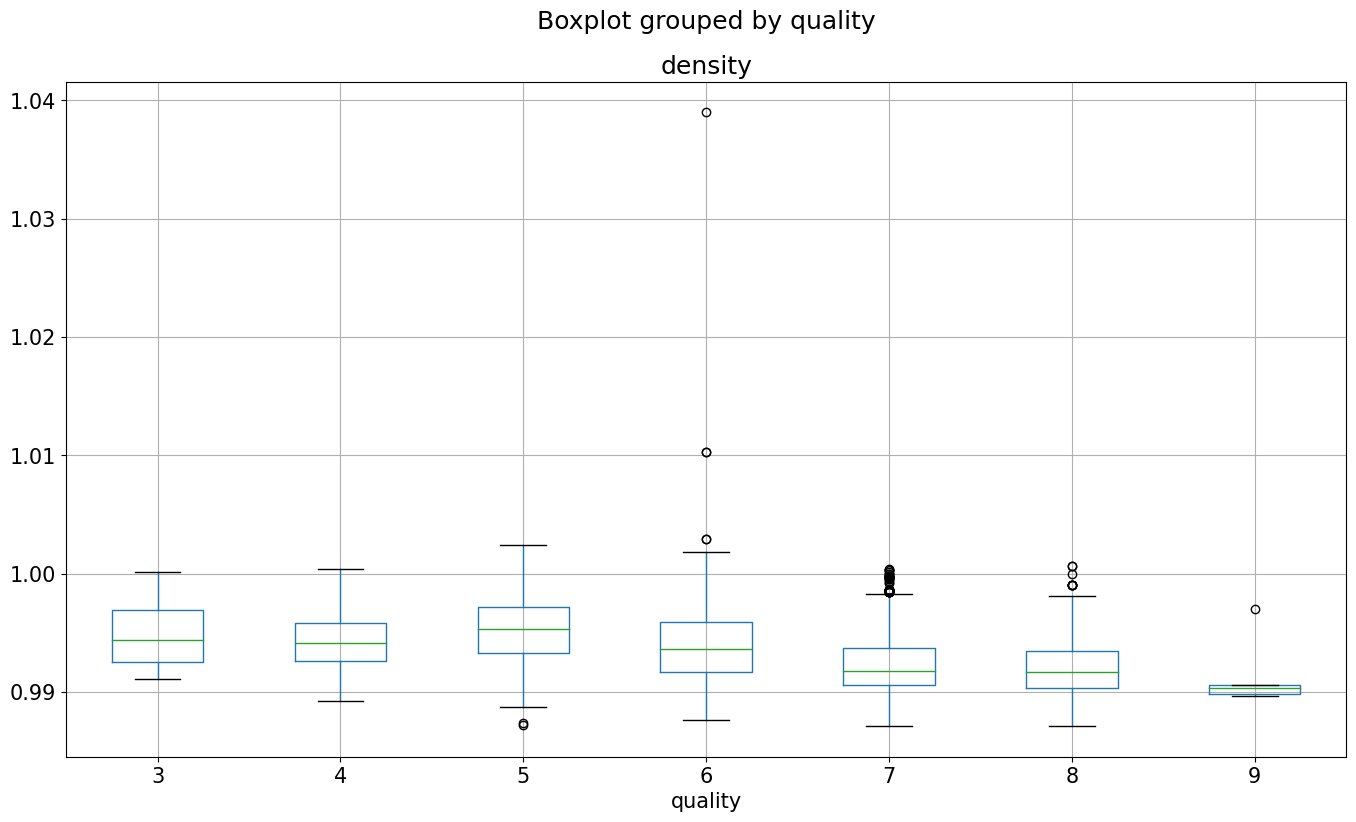

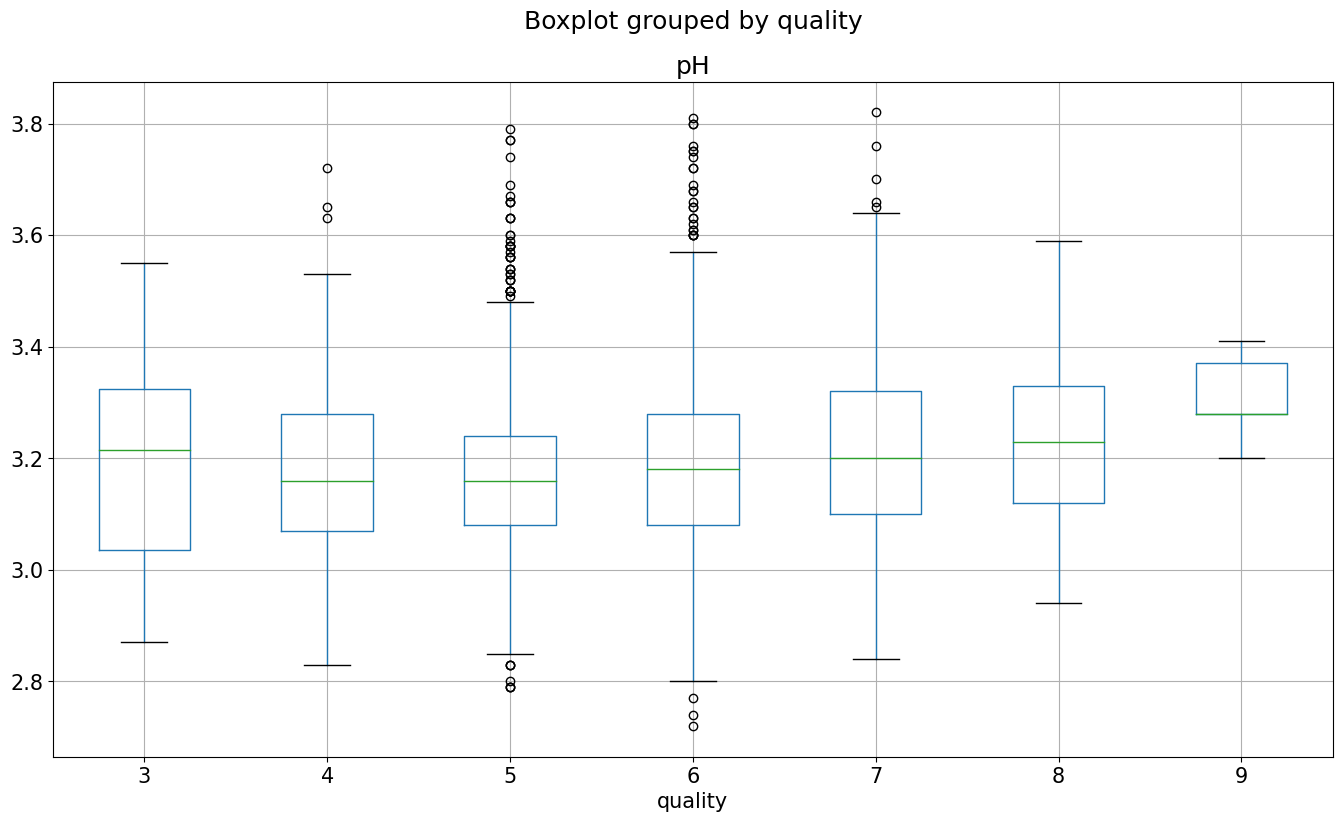

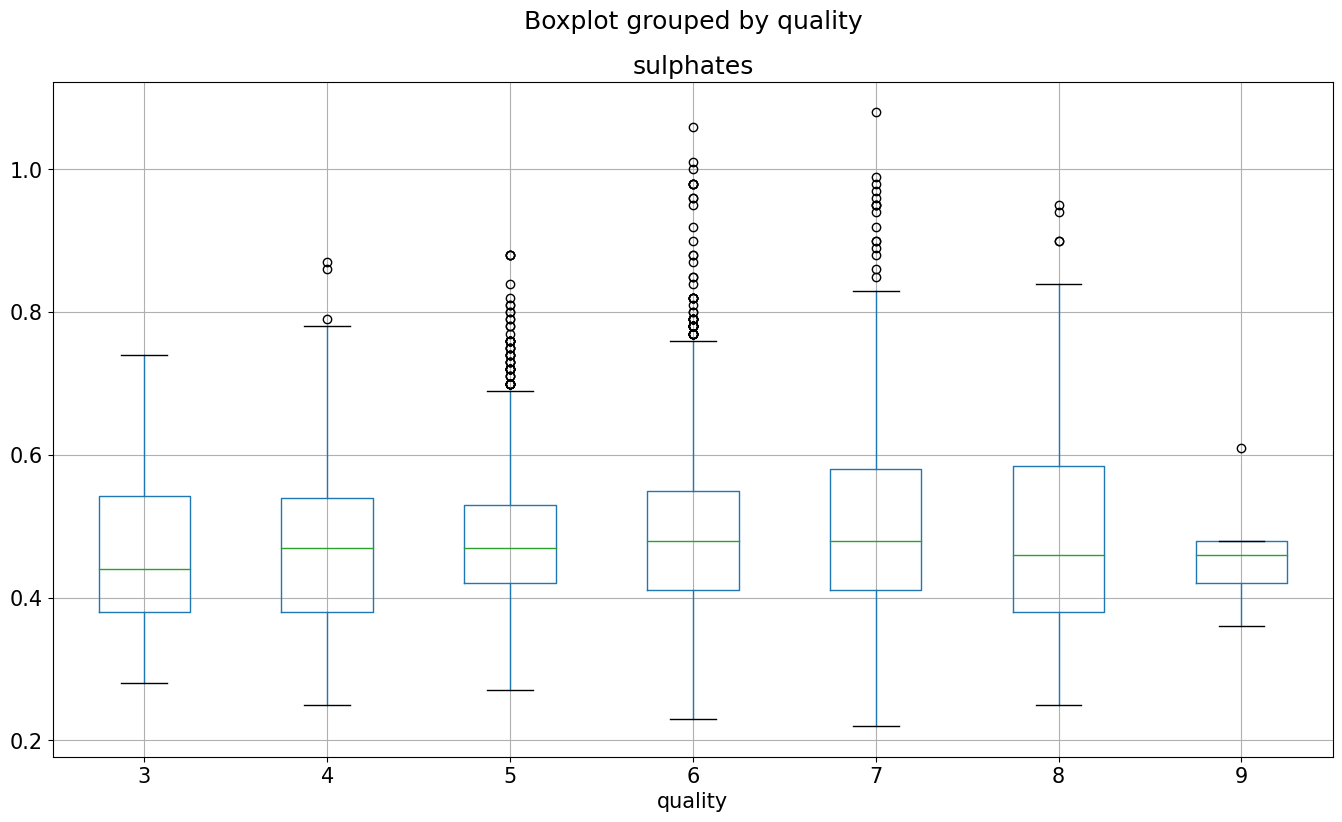

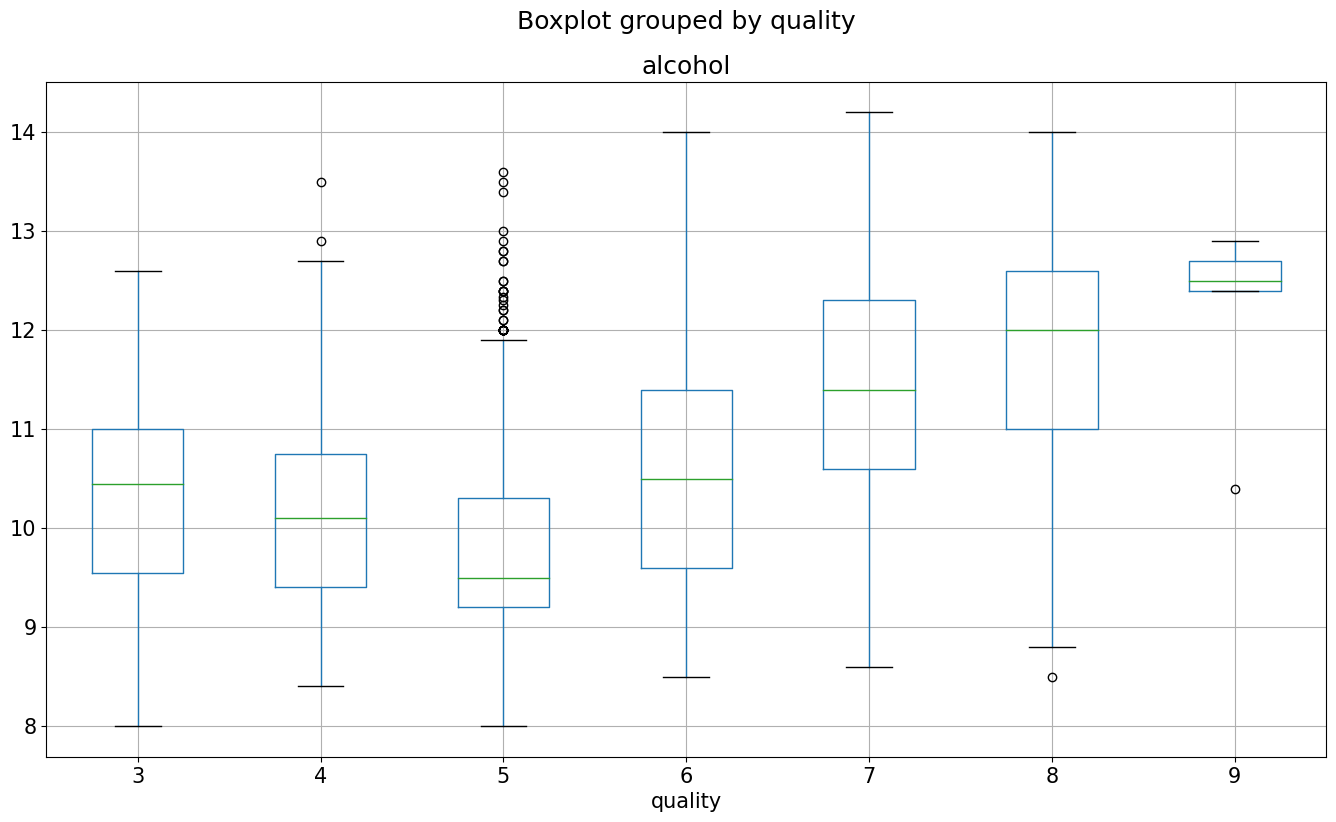

In [36]:
# Mean and Standard Pearson deviation

print('Mean values for each variable\n{}\n'.format(data.mean()))
print('Median values for each variable\n{}\n'.format(data.median()))
print('Modes for each variable\n{}\n'.format(data.mode()))
print('Standard Pearson deviation values for each variable\n{}\n'.format(data.std()))

# Boxplot for each variable grouped by the quality values
columns=data.columns.drop(['quality'])

for column in columns:
    data.boxplot(column=column, by='quality')
    plt.show()


### B. Pearson Correlation

In [ ]:
# TODO
# - distribution
# - (FAIT) matrice de correlation (pearson correlation)
# std, mean, boite moustache etc...
# distribution par note

data.describe()

corr = data.corr(method='pearson')
display(corr.style.background_gradient(cmap='coolwarm').set_precision(2))
# classement:
# top = abs(corr.loc[Y_COL_NAME]).sort_values(ascending=False)
top = corr.loc[Y_COL_NAME][corr.index != Y_COL_NAME]
sorted = abs(top).sort_values(ascending=False)
display(top) # en abs car -1 donne une bonne correlation aussi (correlation negative)
fig, ax = plt.subplots()
ax.bar(x=sorted.index, height=top[sorted.index], width=1, edgecolor='black')
ax.set_title("Classement des correlations des variables par rapport à la variable \"quality\"", fontdict={"size":25})
for i, v in enumerate(top[sorted.index].values):
    ax.text(i - 0.25, (v + np.sign(v) * 0.015) - 0.01, f"{round(v, 2):.2f}", color='black')
# plt.axhline(1, linestyle='--')
# plt.axhline(-1, linestyle='--')
plt.ylabel("Pearson correlation", fontweight='light', fontsize='x-large')
plt.xticks(rotation=67.5, horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontweight='light', fontsize='small')
plt.show()

# II. Data preparation

In [ ]:
NB_CLASS = 10

X = data.loc[:, data.columns != Y_COL_NAME]
# X = ((X - X.mean()) / X.std()).values # Standardization colonne par colonne # (x - µ) / σ
# ou
X = ((X - X.min()) / (X.max() - X.min())).values # min-max scaling => 0 - 1 # (x - min) / (max - min)
# Jmais compris c'etait quoi le mieux : https://kharshit.github.io/blog/2018/03/23/scaling-vs-normalization

Y = data.loc[:, Y_COL_NAME].values
Y = Y.reshape(-1, 1) # Y est scale entre 0 et 1 au moment de faire la regression (on garde les notes en entier pour le model de classif)

NB_INPUT = X.shape[1] # nombre de variable en input des modeles
NB_DATA = X.shape[0]
# X, Y, X.shape, Y.shape

# Split train/test/validation
pTrain, pTest, pValidation = (0.80, 0.10, 0.10)
assert (pTrain + pTest + pValidation) == 1.0, f"La somme doit etre equel à 1, {pTrain, pTest, pValidation}"
SPLIT_TRAIN = int(NB_DATA * pTrain)
SPLIT_TEST = int(NB_DATA * pTest)
SPLIT_VAL = int(NB_DATA * pValidation)
print(SPLIT_TRAIN, SPLIT_TEST, SPLIT_VAL)
X_train, X_test, X_val = X[:SPLIT_TRAIN], X[SPLIT_TRAIN:SPLIT_TRAIN+SPLIT_TEST], X[-SPLIT_VAL:]
Y_train, Y_test, Y_val = Y[:SPLIT_TRAIN], Y[SPLIT_TRAIN:SPLIT_TRAIN+SPLIT_TEST], Y[-SPLIT_VAL:]
print(X_train.shape, X_test.shape, X_val.shape)
print(Y_train.shape, Y_test.shape, Y_val.shape)

# III. Models

In [ ]:
def classification_model():
	input = Input(shape=(NB_INPUT,), name="input")
	x = Dense(1000, activation="relu")(input)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(500, activation="relu")(x)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(250, activation="relu")(x)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	output = Dense(NB_CLASS, activation=Softmax(), name="prediction")(x)
	
	return Model(input, output, name="classification_model")

# regression_model().summary()
# classification_model().summary()

# yt, yp = tf.constant([0,1,2,3,4,5,6,7,8,9]) / 10, tf.constant([0.05,0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
# print(yt, yp)
# regression_accuracy(yt, yp)

In [ ]:
classModel = classification_model()
classModel.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=Adam(learning_rate=0.0001))
classModel.summary()

hclass = classModel.fit(X_train, Y_train, validation_data=[X_test, Y_test], batch_size=32, epochs=50)

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hclass.history["loss"], label="train loss")
plt.plot(hclass.history["val_loss"], label="test loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,9))
plt.plot(hclass.history["accuracy"], label="train accuracy")
plt.plot(hclass.history["val_accuracy"], label="test accuracy")
plt.legend()
plt.show()

In [ ]:
plt.plot(np.array(hclass.history["val_loss"]) / np.array(hclass.history["loss"]), label="ratio test/train loss")
plt.axhline(y=1, color='b', linestyle='--', label="Equilibre")
plt.legend()
# Pour evaluer le surapprentissage (plus on s'eloigne de 1 en positif plus on est en surapprentisssage)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
Y_pred = np.argmax(classModel.predict(X_train), axis=1)
Y_true = Y_train.reshape(-1,)
cm = confusion_matrix(Y_true, Y_pred, labels=np.arange(0, 10))
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g')
plt.show()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='.2f')

In [ ]:
Y_pred = np.argmax(classModel.predict(X_test), axis=1)
Y_true = Y_test.reshape(-1,)
cm = confusion_matrix(Y_true, Y_pred, labels=np.arange(0, 10))
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g')
plt.show()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='.2f')

# IV Evaluations

In [ ]:
# TODO Cross Val pour test different meta parametre
# plot les resultats + leur std par epochs

# TODO tester l'accuracy de la classif en faisant apparaitre aussi le seconde choix du model
# possible aussi de regarder si les deux premier choix sont "proche" (cad si une prediction à 5 en choix 1 est suivit par un 4 ou 6 en choix 2 (faisable en faaisant mean(abs(choix1-choix2)))))

# V Conclusion

In [ ]:
# TODO Conclure
# TODO souligner les limites du dataset: que 3 votants, manque d'element en input comme le prix, les labels de qualité etc pour que le model soit pertinent dans le cadre d'une utilisation de classification de vin en situation de vente reel